___
# <font color= #d4b1e6> **Proyecto 1: Análisis de Sentimientos** </font>
- <Strong> Nombre de los integrantes: </Strong>  <font color="blue">`Sarah Lucía Beltrán, Priscila Cervantes Ramírez & Mónica Ibarra Herrera` </font>
- <Strong> Materia: </Strong>  <font color="blue">`Minería de Textos` </font>
___

A continuación se trabajará con un dataset que contiene reseñas de películas que están etiquetadas como positivas y negativas.

En este proyecto se implementarán y compararán modelos basados en n-grams (unigramas, bigramas y trigramas) enfocados en la clasificación de texto. El objetivo es evaluar cómo los diferentes tamaños de n-gramas influyen en el desempeño de los algoritmos que se emplearán. 

Los modelos que se incluirán son los siguientes:
- Regresión Logística 
- Naive Bayes
- SVM

Para cada uno de los modelos mencionados anteriormente se obtendrán diferentes métricas como Accuracy, Precision, Recall y F1-Score.

Se harán evaluaciones y se determinará cuál fue el modelo con el mejor desempeño, así como se revisarán algunos errores que hicieron los modelos para identificar por qué predijo mal, ya sea porque la reseña era de sarcasmo, negación, etc.

### <font color= #d4b1e6> **Librerías a utilizar** </font>

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import random

### <font color= #d4b1e6> **Importación de los datos** </font>

In [21]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


*Visualizar que no haya valores nulos*

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### <font color= #d4b1e6> **División train/test** </font>

In [23]:
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42, stratify=df['sentiment'])

print("Tamaño train:", len(train_df))
print("Tamaño test:", len(test_df))


Tamaño train: 25000
Tamaño test: 25000


Se usarán el 50% es decir 25,000 reseñas para entrenar a los modelos y las reseñas restantes, se usarán para probar su rendimiento.

### <font color= #d4b1e6> **Pre-Procesamiento** </font>

In [24]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cesar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Se utilizó la librería NLTK (Natural Language Toolkit) para realizar la tokenización del texto. Para ello fue necesario descargar los recursos *punkt*, *punkt_tab* y *stopwords*.

- *punkt* permite dividir de manera automática un texto en oraciones y palabras (tokens). 

- *punkt_tab* contiene información extra para que funcione de manera correcta el tokenizador.

- *stopwords* que contiene un listado de palabras muy frecuentes en el idioma (como the, is, and) que suelen eliminarse por no aportar valor al analizar texto.

De esta forma, se asegura que cada reseña se transforme en una secuencia de palabras significativas antes de construir representaciones con n-gramas.

*Limpieza de reseñas*

In [25]:
STOPWORDS = set(stopwords.words("english"))
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

- *STOPWORDS* importa una lista de stopwords en inglés desde NLTK y las convierte en un conjunto para que las búsquedas sean más rápidas cuando se filtre texto.
- *PUNCT_TABLE* crea una tabla de traducción que sirve para eliminar todos los signos de puntuación, limpia el texto quitando las puntuaciones.

In [26]:
def preprocess_text(text, remove_stopwords=False):
    # Minúsculas
    text = text.lower()
    # Eliminar HTML
    text = re.sub(r"<.*?>", " ", text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar tokens que no son alfanuméricos
    tokens = [t for t in tokens if any(c.isalnum() for c in t)]
    # Eliminar stopwords si se requiere
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    return " ".join(tokens)

# Aplicamos a train y test
train_df["clean_review"] = train_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))
test_df["clean_review"] = test_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))

train_df.head()

,review,sentiment,clean_review
3055,Trio's vignettes were insightful and quite enj...,positive,trio 's vignettes were insightful and quite en...
47326,I had never heard of this one before the owner...,negative,i had never heard of this one before the owner...
48869,This is an excellent but hard to find trippy W...,positive,this is an excellent but hard to find trippy w...
48623,"I am a huge fan of big, loud, trashy, complete...",positive,i am a huge fan of big loud trashy completely ...
39657,"Easily Lucio Fulci's most respected film, ""Don...",positive,easily lucio fulci 's most respected film do n...


Se implementa una función de preprocesamiento de texto que:

1) Convierte todo a minúsculas.

2) Elimina etiquetas HTML.

3) Tokeniza las reseñas en palabras individuales.

4) Filtra tokens que no son letras o números como signos de puntuación

5) Opcionalmente elimina stopwords.

Se decidió no eliminar las stopwords durante el preprocesamiento, ya que en análisis de sentimientos estas palabras pueden cambiar el significado de una oración. Palabras como ‘not’, ‘never’ o ‘don’t’ son esenciales para que el modelo identifique correctamente si la reseña es positiva o negativa. 

De esta manera, se obtiene una columna clean_review con texto más limpio y normalizado, que facilita el posterior análisis y entrenamiento del modelo de clasificación.

*Extracción de características*

In [27]:
# Definir el vectorizador con unigramas, bigramas y trigramas
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=50000) # max_features: limita vocabulario para no explotar la RAM

#  Ajustar al train y transformar
X_train = vectorizer.fit_transform(train_df["clean_review"])
X_test = vectorizer.transform(test_df["clean_review"])

y_train = train_df["sentiment"]
y_test = test_df["sentiment"]

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (25000, 50000)
Shape X_test: (25000, 50000)


Para representar las reseñas se utilizó un CountVectorizer de Scikit-learn para extraer unigramas, bigramas y trigramas. Esto significa que cada reseña se transforma en un vector que refleja la frecuencia de palabras individuales y combinaciones de dos o tres palabras consecutivas. Se limitó el vocabulario a 50,000 características para reducir el consumo de memoria.

El vectorizador se ajusta al conjunto de entrenamiento y luego se aplica al conjunto de prueba usando el mismo vocabulario aprendido, asegurando que la evaluación sea consistente. Las etiquetas de sentimiento se almacenan por separado en y_train y y_test, y las dimensiones de las matrices resultantes reflejan el número de reseñas y la cantidad de n-gramas considerados.

### <font color= #d4b1e6> **Entrenamiento de Modelos** </font> 

#### <font color= #96d9cf> **Regresión Logística** </font> 

In [28]:
logreg = LogisticRegression(max_iter=1000, solver="saga")
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

c:\Users\cesar\anaconda3\envs\iteso\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


*Explicación de hiperparámetros*

Para entrenar el modelo de Regresión Logística se utilizó LogisticRegression de Scikit-learn con los hiperparámetros max_iter=1000 y solver="saga".

- *max_iter* de 1000 para asegurar que el algoritmo converja, dado el tamaño y la alta dimensionalidad de los datos de n-grams.

- *solver="saga"* fue elegido por su eficiencia con matrices dispersas y por su capacidad de manejar regularización L1 y L2, características útiles para textos con muchas características.

#### <font color= #96d9cf> **Naive Bayes** </font>

In [29]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

Se entrenó un modelo Naive Bayes multinomial para clasificar las reseñas en positivas o negativas. Este modelo es adecuado para datos de conteo, como los vectores de n-grams, ya que estima la probabilidad de cada palabra dado el sentimiento de la reseña.

#### <font color= #96d9cf> **SVM** </font>

In [30]:
svm = LinearSVC(C=0.001)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

Se utilizó Support Vector Machine Lineal, adecuado para matrices dispersas de alta dimensionalidad como las obtenidas con n-grams. 

*Explicación de hiperparámetros*:

- C: controla la regularización y penalización de errores.


### <font color= #d4b1e6> **Evaluación** </font> 

In [31]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["positive", "negative"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["positive", "negative"],
                yticklabels=["positive", "negative"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

#### <font color= #96d9cf> **Regresión Logística** </font> 

In [32]:
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

Logistic Regression
Accuracy: 0.90108
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90     12500
    positive       0.90      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



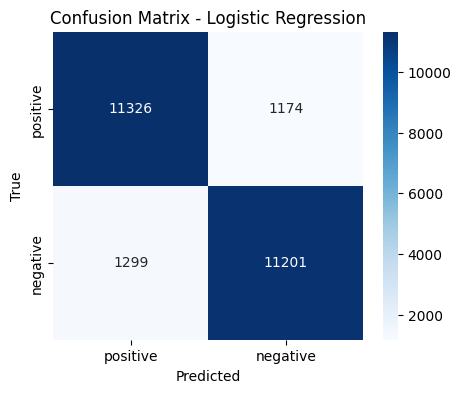

In [33]:
plot_confusion(y_test, y_pred_logreg, "Confusion Matrix - Logistic Regression")

#### <font color= #96d9cf> **Naive Bayes** </font>

In [34]:
print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

Naive Bayes
Accuracy: 0.86692
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87     12500
    positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



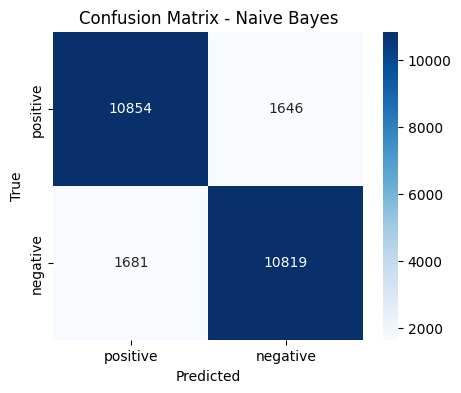

In [35]:
plot_confusion(y_test, y_pred_nb, "Confusion Matrix - Naive Bayes")


#### <font color= #96d9cf> **SVM** </font>

In [36]:
print("SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

SVM
Accuracy: 0.8978
              precision    recall  f1-score   support

    negative       0.90      0.89      0.90     12500
    positive       0.89      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



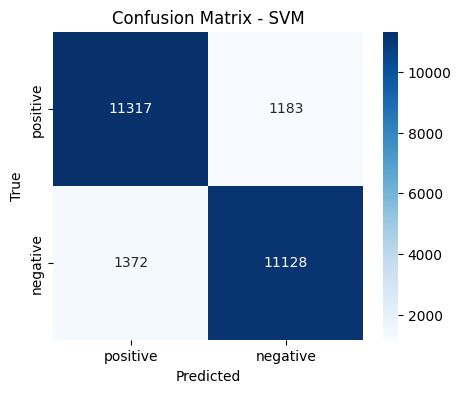

In [37]:
plot_confusion(y_test, y_pred_svm, "Confusion Matrix - SVM")

### <font color= #d4b1e6> **Comparación de resultados** </font> 

| Modelo | Accuracy | F1-Score | Precision | Recall |
|------------|-------|-------|------|--------|
| Regresión logística|0.901|0.9|0.9| 0.9| 
| Naive Bayes|0.866|0.87|0.87|0.87|    
| SVM|0.8651|0.897|0.9|0.9|0.9|

### <font color= #d4b1e6> **Análisis de Error** </font> 

In [38]:
# Escogemos un modelo para analizar (ej. Logistic Regression)
y_pred = y_pred_logreg  

# Encuentra índices de errores
errores_idx = [i for i, (y_true, y_hat) in enumerate(zip(y_test, y_pred)) if y_true != y_hat]

print("Total errores:", len(errores_idx))

# Muestra algunos ejemplos al azar usando el texto original
for i in random.sample(errores_idx, 5):
    print("="*80)
    print("🔹 Review original:")
    print(test_df.iloc[i]["review"])   # aquí usamos test_df, no X_test
    print("Sentiment real:", test_df.iloc[i]["sentiment"])
    print("Predicción modelo:", y_pred[i])

Total errores: 2473
🔹 Review original:
This is a really well made movie. Sumitra Bhave has always made sensible cinema and this is my favourite film by her. This movie should have won the National Award and would have been my pick to represent India at the Oscars. It is at least a thousand times better than 'Shaaws', which is going to the Oscars, from India, this year.<br /><br />It is such a pity that the information about this (and all other Indian movies) on IMDb is lacking and sometimes even wrong. Sadashiv Amrapurkar played a very important character in this movie and he is not even credited on these pages. The rest of the cast and crew too are not mentioned at all. Awards and nominations for this movie are not given even when Sonali Kulkarni won the Indian National Award for this movie. There was not even a single vote cast for 'Doghi'.<br /><br />'Doghi' is not a Hindi movie. It is Marathi, and thankfully escapes the song and dance sequence, does not get tangled up in glitzy gla

### Conclusiones 
---
Al final el modelo que arrojo mejores metricas fue la regresion logistica dandonos .901 de accuracy,0.9 de F1-score, 0.9 de precision y 0.9 de recall. Superando a los demas modelos por aproximadamente 0.04.

Los errores en la prediccion se daban gracias a que le daba peso a las palabras negativas dentro de reseñas positivas, aunque solo se usen para describir escenas, personajes o incluso a la misma aplicación. Otro error, que va de la mano con el anterior, es que se deja guiar por las primeras palabras que hay en la reseña, por esto si una reseña empieza diciendo lo bueno para acabar diciendo que es la pero pelicula, el modelo no lo terminara de entender. También nos percatamos que cuando en una reseña existe ironia no logra comprenderla, asi como no distingue sentimientos hacia la pelicula con los elementos externos. En pocas palabras, el modelo analizaba superficialmente el texto en vez de comprender la intención completa del autor.